# A simple 2D Riemannian Flow Matching model on sphere

## Imports and init device

In [1]:
import time
import torch
import math
import numpy as np

from torch import nn, Tensor

# flow_matching
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.solver import ODESolver, RiemannianODESolver
from flow_matching.utils import ModelWrapper
from flow_matching.utils.manifolds import Sphere, Manifold

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


In [3]:
torch.manual_seed(42)

## Dataset

In [4]:
def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = (torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size, ), device=device) * 2)
    x2 = x2_ + (torch.floor(x1) % 2)

    data = torch.cat([x1[:, None], x2[:, None]], dim=1)

    return data.float()

def wrap(manifold, samples):
    center = torch.cat([torch.zeros_like(samples), torch.ones_like(samples[..., 0:1])], dim=-1)
    samples = torch.cat([samples, torch.zeros_like(samples[..., 0:1])], dim=-1) / 2

    return manifold.expmap(center, samples)

## Model

In [5]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x


# Model class
class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int = 2,
        time_dim: int = 1,
        hidden_dim: int = 128,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.input_layer = nn.Linear(input_dim + time_dim, hidden_dim)

        self.main = nn.Sequential(
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        h = self.input_layer(h)
        output = self.main(h)

        return output.reshape(*sz)


class ProjectToTangent(nn.Module):
    """Projects a vector field onto the tangent plane at the input."""

    def __init__(self, vecfield: nn.Module, manifold: Manifold):
        super().__init__()
        self.vecfield = vecfield
        self.manifold = manifold

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        x = self.manifold.projx(x)
        v = self.vecfield(x, t)
        v = self.manifold.proju(x, v)
        return v

## Train Velocity Flow Matching model

In [6]:
# training arguments
lr = 0.001
batch_size = 4096
iterations = 5001
print_every = 1000
manifold = Sphere()
dim = 3
hidden_dim = 512

# velocity field model init
vf = ProjectToTangent(  # Ensures we can just use Euclidean divergence.
    MLP(  # Vector field in the ambient space.
        input_dim=dim,
        hidden_dim=hidden_dim,
    ),
    manifold=manifold,
)
vf.to(device)

# instantiate an affine path object
path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

# init optimizer
optim = torch.optim.Adam(vf.parameters(), lr=lr) 

# train
start_time = time.time()
for i in range(iterations):
    optim.zero_grad() 

    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
    x_1 = inf_train_gen(batch_size=batch_size, device=device) # sample data
    x_0 = torch.randn_like(x_1).to(device)

    x_1 = wrap(manifold, x_1)
    x_0 = wrap(manifold, x_0)

    # sample time (user's responsibility)
    t = torch.rand(x_1.shape[0]).to(device) 

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

    # flow matching l2 loss
    loss = torch.pow( vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean()

    # optimizer step
    loss.backward() # backward
    optim.step() # update
    
    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
              .format(i+1, elapsed*1000/print_every, loss.item())) 
        start_time = time.time()

| iter   1000 |  6.37 ms/step | loss    0.281 
| iter   2000 |  5.97 ms/step | loss    0.278 
| iter   3000 |  6.10 ms/step | loss    0.277 
| iter   4000 |  6.12 ms/step | loss    0.272 
| iter   5000 |  6.01 ms/step | loss    0.286 


#### Sample from trained model

In [7]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x=x, t=t)

wrapped_vf = WrappedModel(vf)

In [8]:
# step size for ode solver
step_size = 0.01
N = 6

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
eps_time = 1e-2
T = torch.linspace(0, 1, N)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
x_init = wrap(manifold, x_init)

solver = RiemannianODESolver(velocity_model=wrapped_vf, manifold=manifold)  # create an ODESolver class
sol = solver.sample(
    x_init=x_init,
    step_size=step_size,
    method="midpoint",
    return_intermediates=True,
    time_grid=T,
    verbose=True,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.77it/s]


### Visualize the path

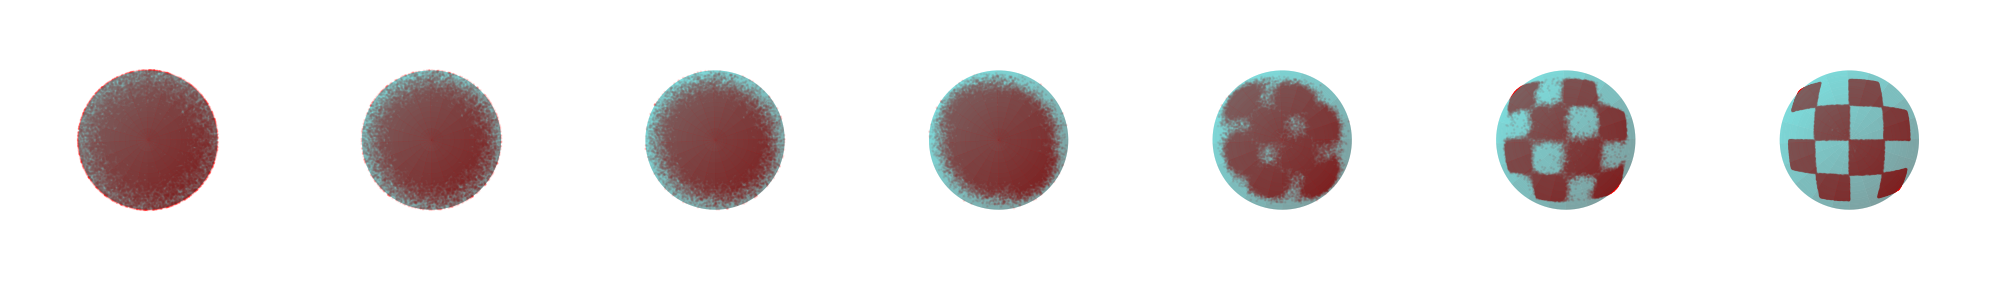

In [9]:
sol = sol.cpu()
T = T.cpu()

gt_samples = inf_train_gen(batch_size=50000)  # sample data
gt_samples = wrap(manifold, gt_samples)

samples = torch.cat([sol, gt_samples[None]], dim=0).numpy()

_, axs = plt.subplots(1, N + 1, figsize=(20, 3.2), subplot_kw={"projection": "3d"})

for i in range(N + 1):
    # Sphere parameters (theta: azimuth, phi: polar angle)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    # Parametric equations for the sphere
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    # Plot the surface of the sphere
    axs[i].plot_surface(x, y, z, color="c", alpha=0.3, rstride=5, cstride=5)

    # Plot only the visible points on the front side of the sphere
    x_points, y_points, z_points = (
        samples[i, :, 0],
        samples[i, :, 1],
        samples[i, :, 2],
    )
    axs[i].scatter(
        x_points, y_points, z_points, color="r", s=1, alpha=0.1
    )  # Red points

    # Set labels
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")
    axs[i].set_zlabel("Z")

    # Set the aspect ratio to equal for better visualization of a sphere
    axs[i].set_box_aspect([1, 1, 1])
    axs[i].view_init(elev=90, azim=0)
    axs[i].axis("off")

plt.tight_layout()
plt.show()